# <center> Delitos en CDMX</center>
## <center> EDA (Categorias Homogenizadas)</center>

## Librerias importantes

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Cargamos nuestros datos

Definimos como variables de tipo `fecha` a $\texttt{fecha_hechos}$ y $\texttt{fecha_inicio}$ y eliminamos dos columnas ($\texttt{ao_inicio}$ y $\texttt{mes_inicio}$) de la base de datos original, ya que sería utilizar información repetida.

In [2]:
FGJ_carpetas = pd.read_csv("../Data/FGJ_carpetas_homo.csv", parse_dates=["fecha_hechos", "fecha_inicio"])
#FGJ_carpetas = pd.read_csv("C:/Users/110395/OneDrive/Documentos/Maestria/Temas Datos/Proyecto/Datos/FGJ_carpetas_homo.csv", parse_dates=["fecha_hechos", "fecha_inicio"])

print(FGJ_carpetas.info())
#print(FGJ_carpetas.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390698 entries, 0 to 1390697
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   fecha_hechos           1390698 non-null  datetime64[ns]
 1   fecha_hechos.1         1390698 non-null  object        
 2   fecha_inicio           1390698 non-null  datetime64[ns]
 3   delito                 1390698 non-null  object        
 4   fiscalia               1390698 non-null  object        
 5   agencia                1390698 non-null  object        
 6   unidad_investigacion   1390698 non-null  object        
 7   categoria_delito       1390698 non-null  object        
 8   colonia_hechos         1390698 non-null  object        
 9   alcaldia_hechos        1390698 non-null  object        
 10  longitud               1390698 non-null  float64       
 11  latitud                1390698 non-null  float64       
 12  delito_homo            13906

Definimos como indicies las fechas cuando ocurrieron los hechos delictivos, es decir, con la variable $\texttt{fecha_hechos}$

In [3]:
FGJ_carpetas.index = pd.DatetimeIndex(FGJ_carpetas.fecha_hechos)

Mostramos los primeros 3 registros, solo para comprobar como fueron cargados nuestros datos

In [6]:
FGJ_carpetas.head(3)

,fecha_hechos,Unnamed: 0,ao_hechos,mes_hechos,fecha_hechos.1,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,categoria_delito,colonia_hechos,alcaldia_hechos,longitud,latitud,categoria_delito_homo,delito_homo
fecha_hechos,,,,,,,,,,,,,,,,,
2016-01-31 22:16:00,2016-01-31 22:16:00,1,2016,Enero,2016-01-31 22:16:00,2016-02-01 00:25:44,DANO EN PROPIEDAD AJENA INTENCIONAL,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-2,UI-3CD,DELITO DE BAJO IMPACTO,AMÉRICAS UNIDAS,BENITO JUAREZ,-99.140215,19.380315,DELITO DE BAJO IMPACTO,DANO EN PROPIEDAD AJENA INTENCIONAL
2016-01-31 20:50:00,2016-01-31 20:50:00,2,2016,Enero,2016-01-31 20:50:00,2016-02-01 00:52:37,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,INVESTIGACIÓN PARA LA ATENCIÓN DEL DELITO DE R...,ORIENTEII,UI-3CD,ROBO DE VEHICULO CON Y SIN VIOLENCIA,LOS CIPRESES,IZTAPALAPA,-99.108403,19.352859,ROBO DE VEHICULO CON Y SIN VIOLENCIA,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...
2016-02-01 00:30:00,2016-02-01 00:30:00,3,2016,Febrero,2016-02-01 00:30:00,2016-02-01 01:33:26,NARCOMENUDEO POSESION SIMPLE,"INVESTIGACIÓN PARA LA ATENCIÓN DE NIÑOS, NIÑAS...",57,UI-3CD,DELITO DE BAJO IMPACTO,UNIDAD VICENTE GUERRERO,IZTAPALAPA,-99.061321,19.356451,DELITO DE BAJO IMPACTO,NARCOMENUDEO POSESION SIMPLE


## EDA
Vemos cuantos registros tenemos por tipo de delito. Algo *interesante* a remarcar son los feminicidios, ya que solo se ve 1 registrado y si prestamos atención en las noticias del día a día, podemos pensar que debería haber más registros.

In [7]:
FGJ_carpetas["categoria_delito_homo"].value_counts()

DELITO DE BAJO IMPACTO                                             374896
ROBO DE OBJETOS                                                    195601
VIOLENCIA FAMILIAR                                                 159645
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA               114950
FRAUDE                                                              86405
ROBO A NEGOCIO SIN VIOLENCIA                                        86013
AMENAZAS                                                            83310
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                                69732
HECHO NO DELICTIVO                                                  49673
ROBO A CASA SIN VIOLENCIA                                           36100
ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA     29925
OTROS DELITOS DE INDOLE SEXUAL                                      23308
ROBO A NEGOCIO CON VIOLENCIA                                        22717
ROBO A REPARTIDOR CON Y SIN VIOLENCIA 

Graficamos la información anterior

<AxesSubplot:title={'center':'Tasa de delitos cometidos entre 2016-2022'}>

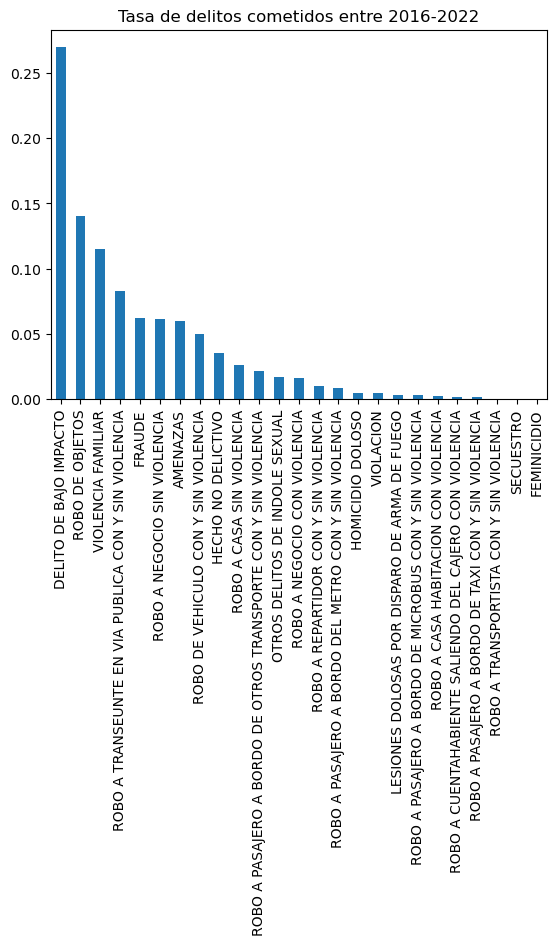

In [8]:
FGJ_carpetas["categoria_delito_homo"].value_counts(normalize=True).plot(kind = "bar", 
                                                                   title = "Tasa de delitos cometidos entre 2016-2022")

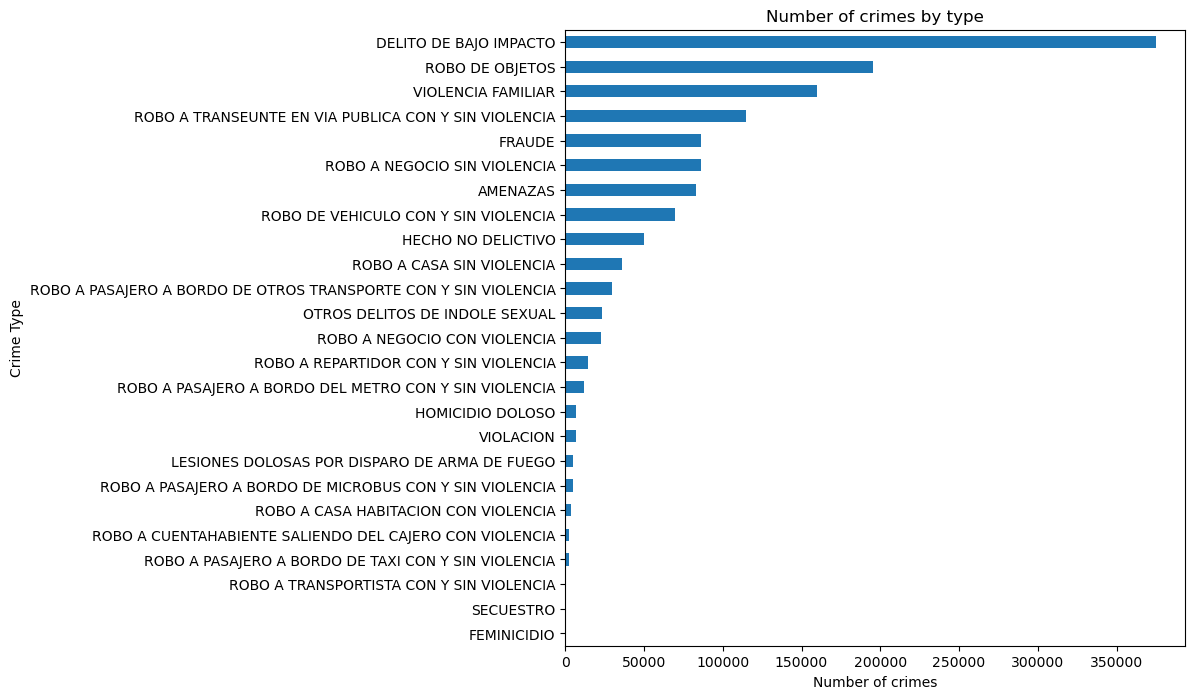

In [9]:
plt.figure(figsize=(8,8))
FGJ_carpetas.groupby([FGJ_carpetas['categoria_delito_homo']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

Nos llama la atención que la categoría de **Delitos de bajo impacto** contiene 198 delitos de diferente naturalza aún despues de realizar el procesos de homogenización. A continuación, mostramos las primeras clases de delitos más frecuentes que son considerados de bajo impacto. 

In [19]:
pd.DataFrame(FGJ_carpetas[FGJ_carpetas["categoria_delito_homo"] == "DELITO DE BAJO IMPACTO"]["delito"].value_counts()).reset_index()[0:20]

,index,delito
0,ABUSO DE CONFIANZA,23453
1,NARCOMENUDEO POSESION SIMPLE,21899
2,DANO EN PROPIEDAD AJENA CULPOSA POR TRANSITO V...,21866
3,USURPACION DE IDENTIDAD,18799
4,FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...,18137
5,LESIONES INTENCIONALES POR GOLPES,16232
6,DANO EN PROPIEDAD AJENA INTENCIONAL,15496
7,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,15130
8,TENTATIVA DE EXTORSION,11616
9,DANO EN PROPIEDAD AJENA CULPOSA,11504


Al analizar los delitos etiquetados en la categoría de "HOMICIDIO DOLOSO" encontramos delitos de diversa indole, entre los cuales se encuentra más carpetas de feminicidios. 

In [9]:
pd.DataFrame(FGJ_carpetas[FGJ_carpetas["categoria_delito_homo"] == "HOMICIDIO DOLOSO"]["delito"].value_counts()).reset_index()[0:20]

,index,delito
0,HOMICIDIO POR ARMA DE FUEGO,4553
1,HOMICIDIO POR ARMA BLANCA,920
2,HOMICIDIOS INTENCIONALES (OTROS),519
3,HOMICIDIO POR GOLPES,499
4,FEMINICIDIO,251
5,FEMINICIDIO POR ARMA BLANCA,49
6,FEMINICIDIO POR DISPARO DE ARMA DE FUEGO,38
7,FEMINICIDIO POR GOLPES,25
8,HOMICIDIO POR AHORCAMIENTO,17
9,HOMICIDIO POR INMERSION,1


Vemos la cantidad de registros de delitos cometidos por año.

In [9]:
FGJ_carpetas["ao_hechos"].value_counts().sort_index()

2016    187319
2017    218043
2018    244732
2019    235368
2020    195039
2021    211468
2022     98729
Name: ao_hechos, dtype: int64

Podemos ver que para el año 2022 hay pocos delitos, lo que no es de sorprenderse ya que el año aun esta en curso. 

Algo que si hay que notar, es que a partir del 2019 se nota una disminución en la cantidad de delitos, sobre todo para el año 2020, esto podría se un efecto de las medidas y situaciones provocadas por el COVID. Quizás haya que considerar este efecto para futuros análisis.

<AxesSubplot:>

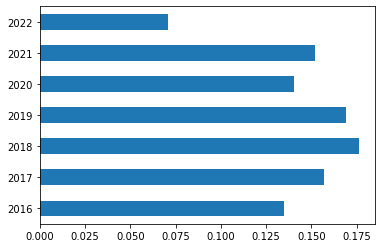

In [10]:
FGJ_carpetas["ao_hechos"].value_counts(normalize=True).sort_index().plot(kind = "barh")

Cantidad de delitos por mes.

In [11]:
FGJ_carpetas["mes_hechos"].value_counts().sort_index()

Abril         118921
Agosto        110892
Diciembre     102998
Enero         121395
Febrero       121297
Julio         106360
Junio         119038
Marzo         131641
Mayo          126749
Noviembre     108552
Octubre       115089
Septiembre    107766
Name: mes_hechos, dtype: int64

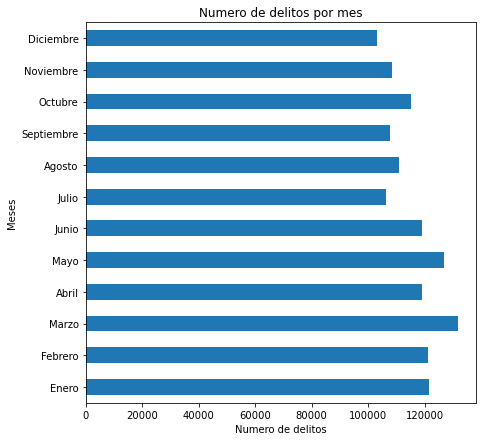

In [12]:
mes = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre",
      "Noviembre", "Diciembre"]
plt.figure(figsize=(7,7))
FGJ_carpetas.groupby([FGJ_carpetas.index.month]).size().plot(kind='barh', title = "Numero de delitos por mes")
plt.xlabel("Numero de delitos")
plt.ylabel("Meses")
plt.yticks(np.arange(12),mes)
plt.show()

Cantidad de delitos por día.

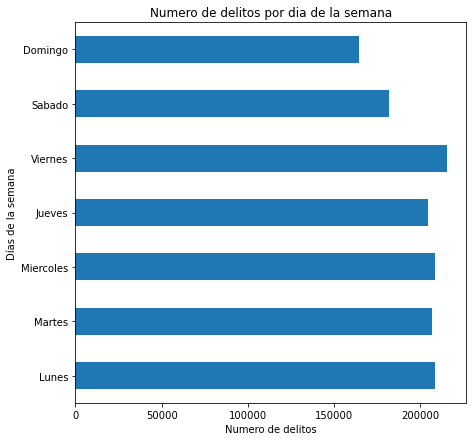

In [47]:
dias = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
plt.figure(figsize=(7,7))
FGJ_carpetas.groupby([FGJ_carpetas.index.dayofweek]).size().plot(kind='barh', title = "Numero de delitos por dia de la semana")
plt.xlabel("Numero de delitos")
plt.ylabel("Días de la semana")
plt.yticks(np.arange(7),dias)
plt.show()

Cantidad de delitos por delegación. Podemos ver como Iztapalapa y Cuahtemoc son más *peligrosos*, por decirlo de alguna manera.

<AxesSubplot:>

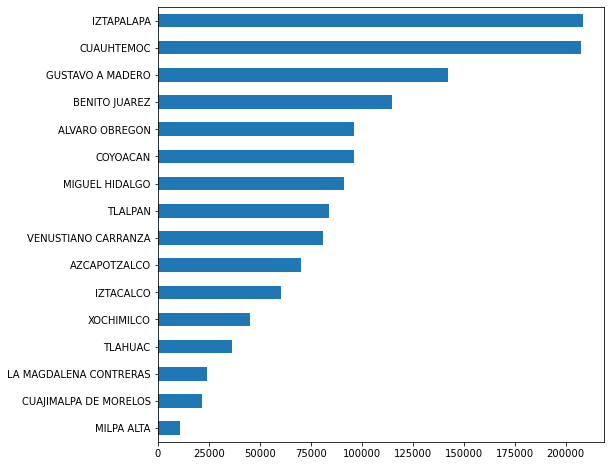

In [14]:
plt.figure(figsize=(8,8))
FGJ_carpetas["alcaldia_hechos"].value_counts().sort_values(ascending=True).plot(kind = "barh")

Vemos las zonas donde mayor se concentran los delitos.

(19.08, 19.6)

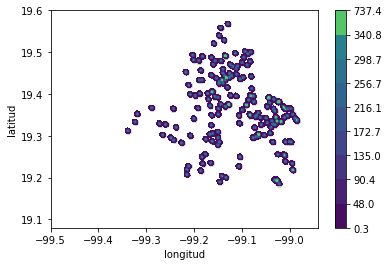

In [29]:
crimes_new = FGJ_carpetas[FGJ_carpetas['categoria_delito_homo'] == 'SECUESTRO']
sns.regplot(x='longitud', y='latitud', data= crimes_new[['longitud','latitud']], fit_reg=False, scatter_kws={"color":"grey","alpha":0.3})
sns.kdeplot(data = crimes_new[['latitud','longitud']], x = "longitud", y="latitud",
                 cmap="viridis", 
                 bw_method=.02,
                 #n_levels=10,
                 cbar=True, 
                 shade=True, 
                 thresh=0.0005, warn_singular=False)
plt.xlim(-99.5,-98.94)
plt.ylim(19.08,19.6)


Ahora lo hacemos por tipo de delito. Algo a mejorar en esta parte es graficar estos puntos sobre el mapa de CDMX para saber en que delegaciones son estas manchas.

In [27]:
FGJ_carpetas["categoria_delito_homo"].unique()

array(['DELITO DE BAJO IMPACTO', 'ROBO DE VEHICULO CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA',
       'VIOLENCIA FAMILIAR',
       'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
       'HECHO NO DELICTIVO', 'ROBO A NEGOCIO SIN VIOLENCIA',
       'ROBO DE OBJETOS', 'AMENAZAS',
       'ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA',
       'ROBO A CASA SIN VIOLENCIA', 'ROBO A NEGOCIO CON VIOLENCIA',
       'OTROS DELITOS DE INDOLE SEXUAL',
       'ROBO A CASA HABITACION CON VIOLENCIA', 'FRAUDE',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
       'VIOLACION', 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA', 'HOMICIDIO DOLOSO',
       'ROBO A PASAJERO A BORDO DE TAXI CON Y SIN VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
       'SECUESTRO', 'FEMINICIDIO'], dtype=object)

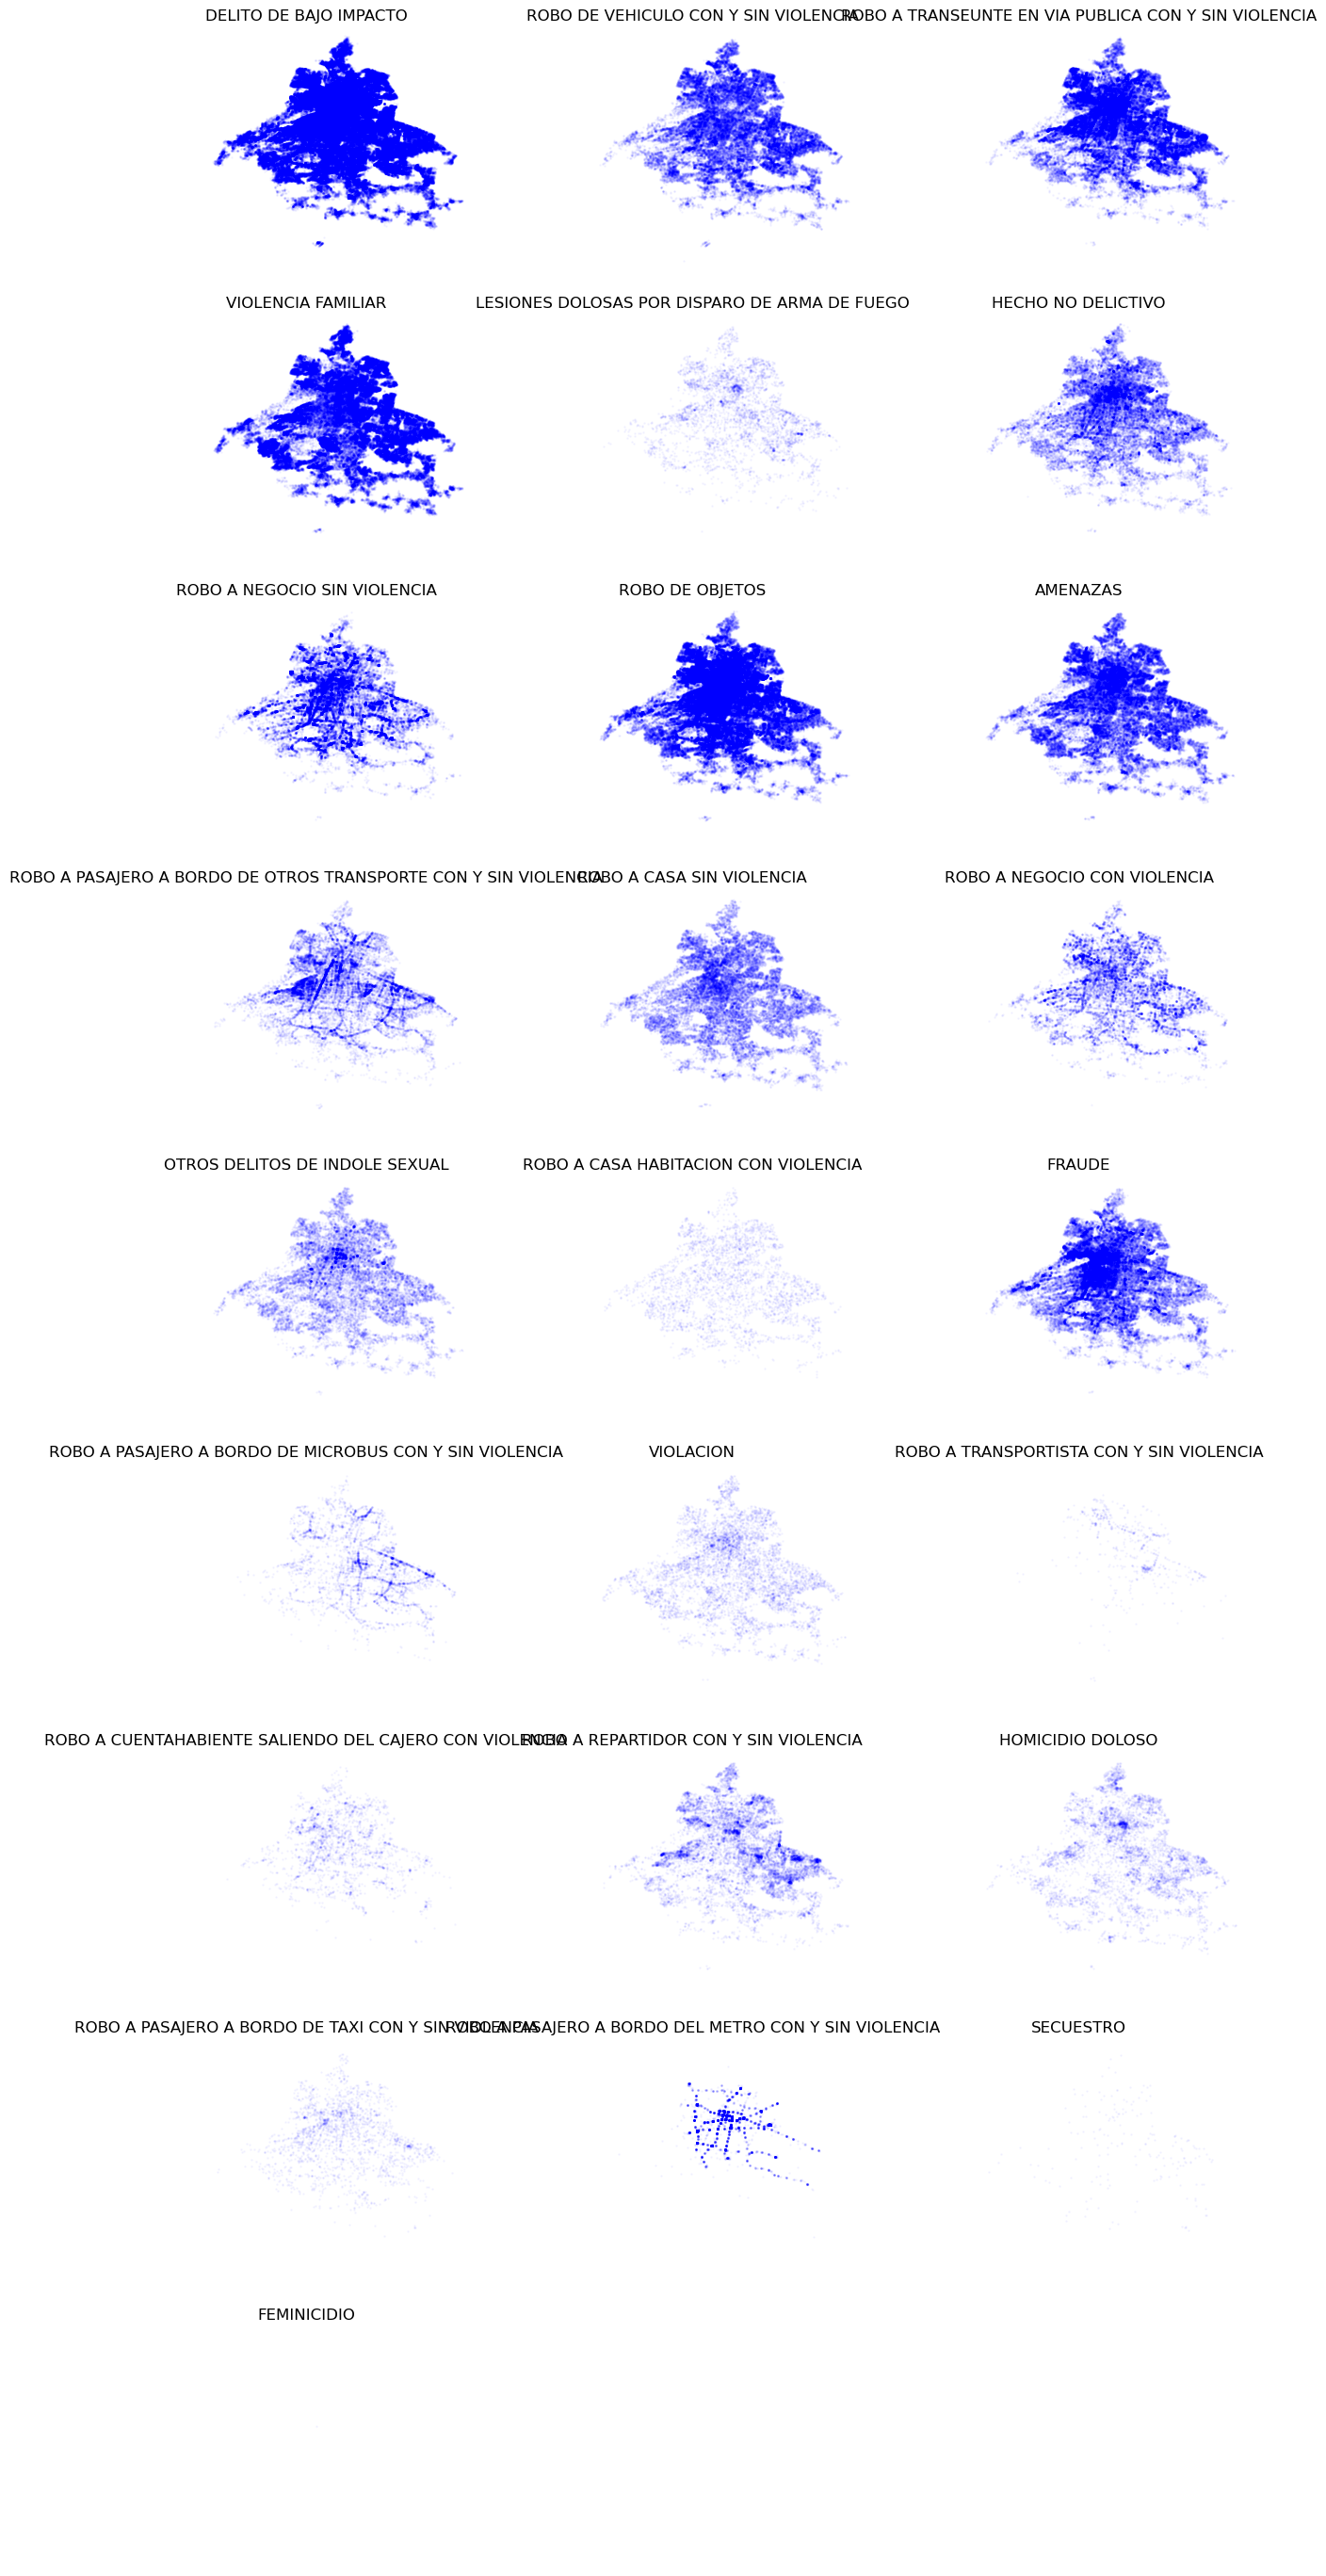

In [28]:
delitos =['DELITO DE BAJO IMPACTO', 'ROBO DE VEHICULO CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA',
       'VIOLENCIA FAMILIAR',
       'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
       'HECHO NO DELICTIVO', 'ROBO A NEGOCIO SIN VIOLENCIA',
       'ROBO DE OBJETOS', 'AMENAZAS',
       'ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA',
       'ROBO A CASA SIN VIOLENCIA', 'ROBO A NEGOCIO CON VIOLENCIA',
       'OTROS DELITOS DE INDOLE SEXUAL',
       'ROBO A CASA HABITACION CON VIOLENCIA', 'FRAUDE',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
       'VIOLACION', 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA', 'HOMICIDIO DOLOSO',
       'ROBO A PASAJERO A BORDO DE TAXI CON Y SIN VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
       'SECUESTRO', 'FEMINICIDIO']

fig = plt.figure(figsize=(15,35))
for i, cat_deli in enumerate(delitos):
    ax = fig.add_subplot(int(np.ceil(float(len(delitos)) / 3)), 3, i+1)
    delitos_cat = FGJ_carpetas[FGJ_carpetas['categoria_delito_homo']==cat_deli]
    sns.regplot(x='longitud', y='latitud', data= delitos_cat[['longitud','latitud']], fit_reg=False, 
                scatter_kws={'alpha':.03, 'color':'blue', "s":1}, ax=ax)
    ax.set_title(cat_deli)
    ax.set_xlim(-99.45,-98.94)
    ax.set_ylim(19.08,19.6)
    ax.set_axis_off()
        
plt.show()

## Series de tiempo

Serie de tiempo por día. Podemos ver que es muy ruidosa.

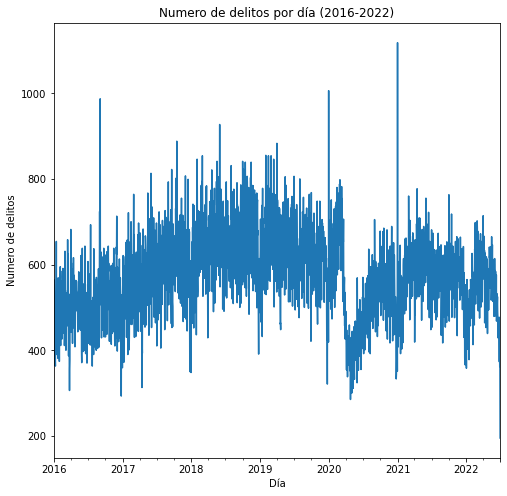

In [19]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("D", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por día (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Día")
plt.show()

Serie por semana.

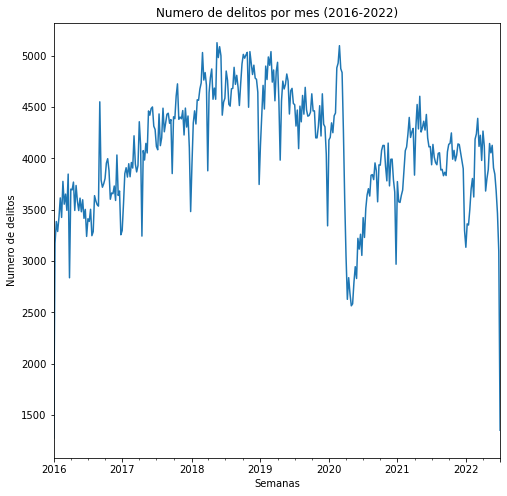

In [36]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("W", on = "fecha_hechos").size().plot(legend = False, 
                                                                               title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Semanas")
plt.show()

Serie mensual.

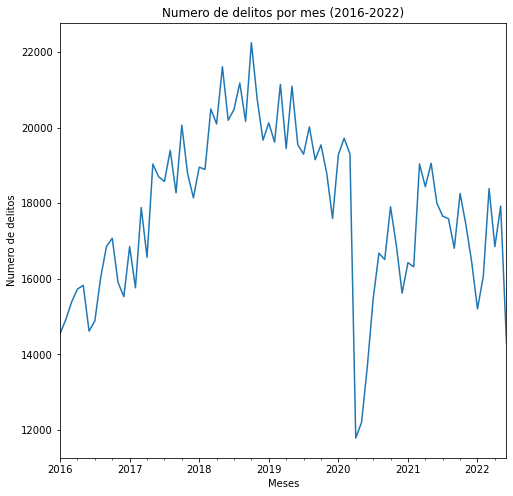

In [21]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("M", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por mes (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Meses")
plt.show()

Serie anual.

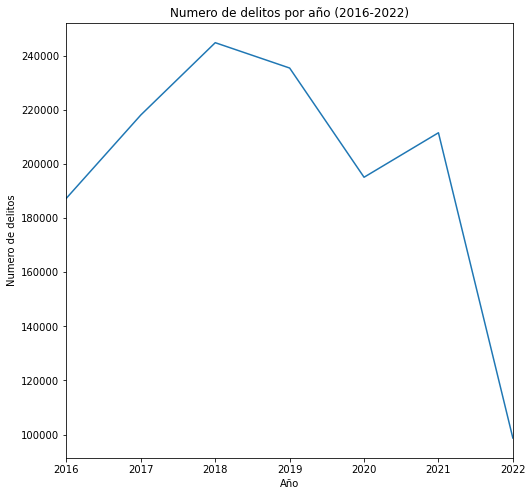

In [22]:
plt.figure(figsize=(8,8))
FGJ_carpetas.resample("Y", on = "fecha_hechos").size().plot(legend = False, title = "Numero de delitos por año (2016-2022)")
plt.ylabel("Numero de delitos")
plt.xlabel("Año")
plt.show()

### Series de tiempo por delito

Utilizando los registros de la base de datos se creo una tabla que contiene el número de delitos registrados dada ciertas ventanas de tiempo para cada uno de los delitos. Por cuestiones de visualización, a continuación solo se muestran las series de tiempo de los 10 delitos con más registros.

In [40]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[:14]

In [41]:
ts_semana = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('W'))

In [42]:
idx_week=np.where(ts_semana.index.week==53)[0]
ts_semana.iloc[idx_week+1,:]=np.ceil((np.array(ts_semana.iloc[idx_week,:])+np.array(ts_semana.iloc[idx_week+1,:]))/2)
ts_semana=ts_semana.loc[ts_semana.index.week!=53,:]

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

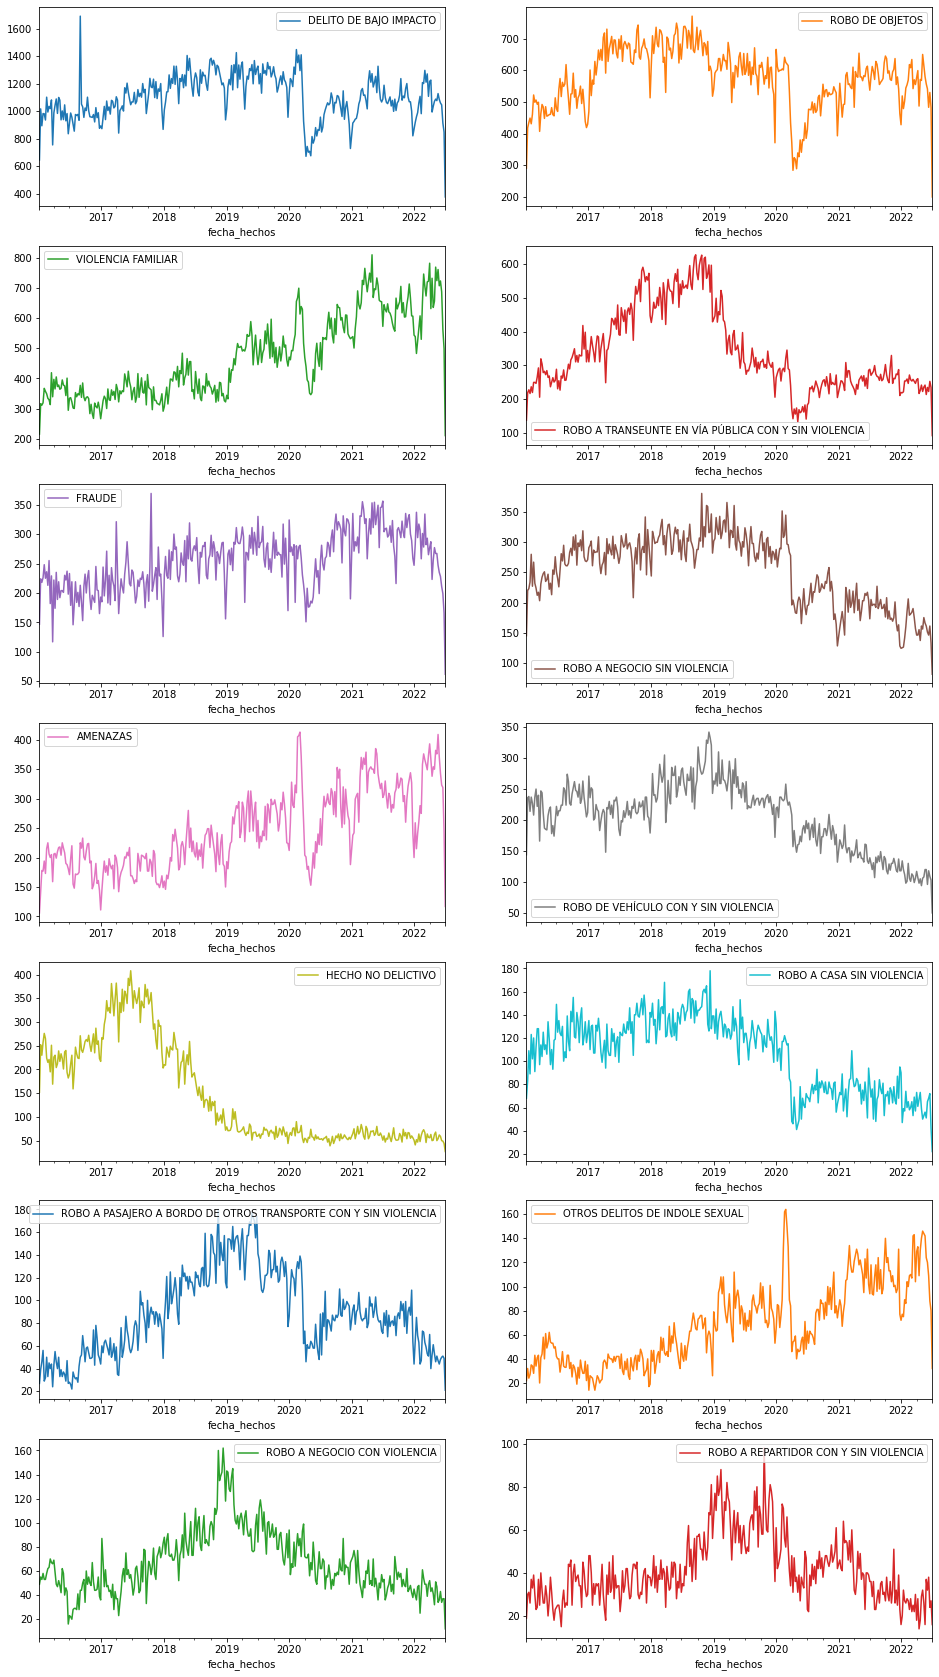

In [43]:
ts_semana.loc[:,top_cat].rolling(1).sum().plot(figsize=(16, 30), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

In [44]:
ts_dia = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('D'))

In [45]:
idx_day=np.where(ts_dia.index.dayofyear==366)[0]
ts_dia.iloc[idx_day+1,:]=np.ceil((np.array(ts_dia.iloc[idx_day,:])+np.array(ts_dia.iloc[idx_day+1,:]))/2)
ts_dia=ts_dia.loc[ts_dia.index.dayofyear!=366,:]

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

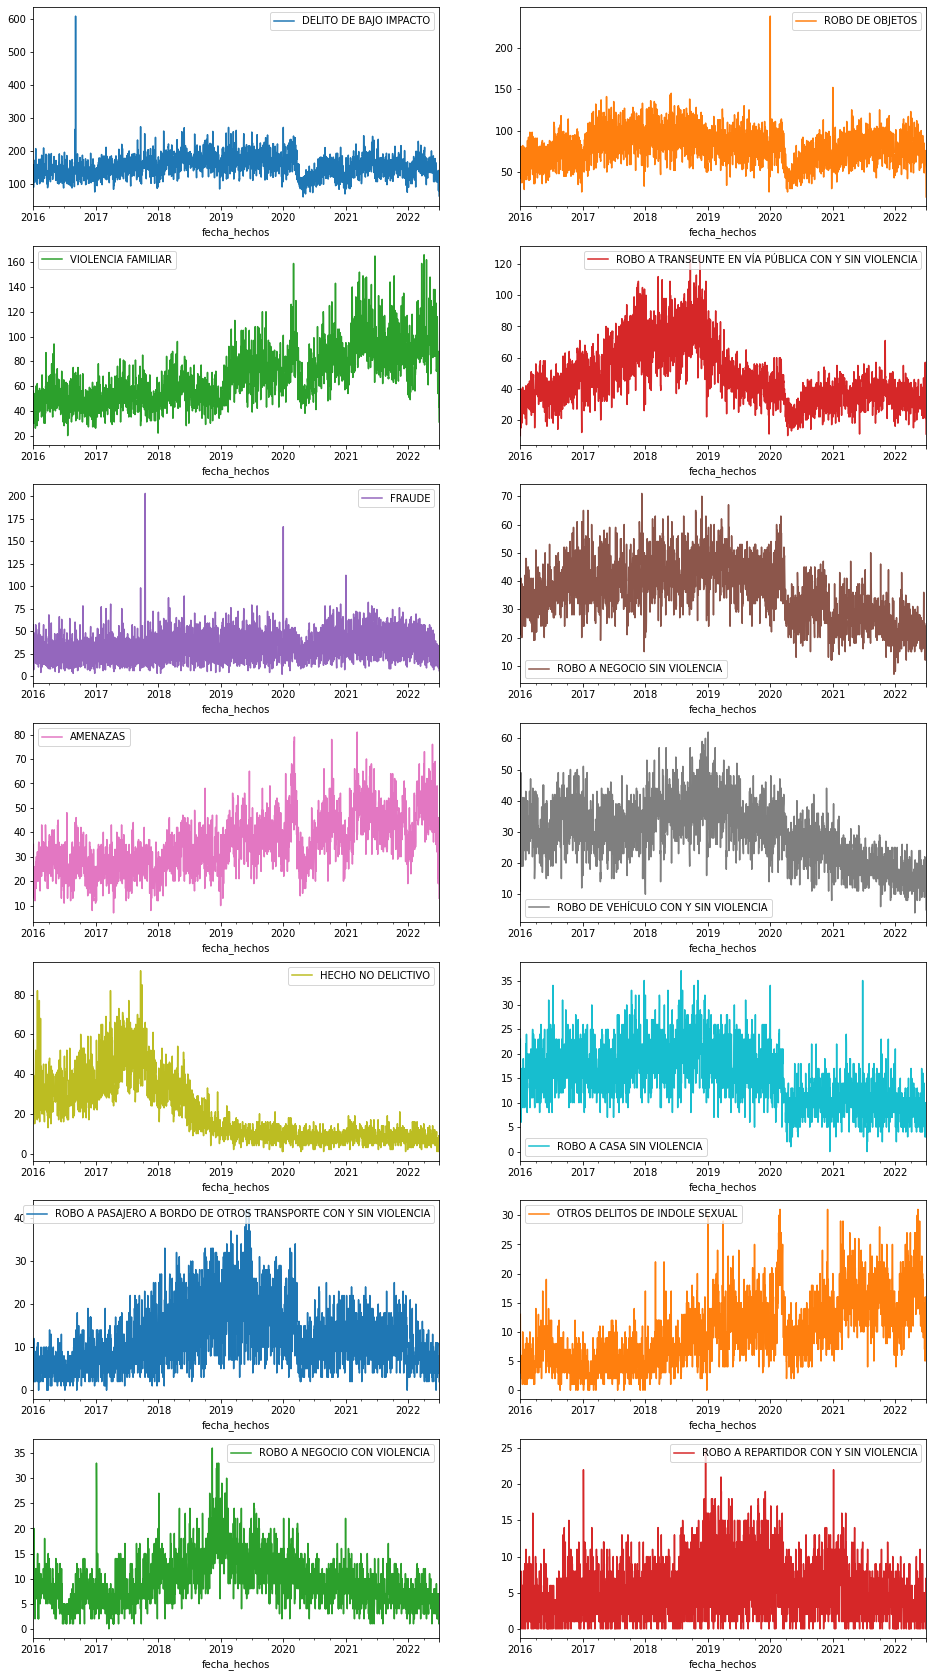

In [46]:
ts_dia.loc[:,top_cat].rolling(1).sum().plot(figsize=(16, 30), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

In [47]:
ts_hora = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", aggfunc=np.size, fill_value=0, 
                                        index=FGJ_carpetas['fecha_hechos'].dt.to_period('H'))

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

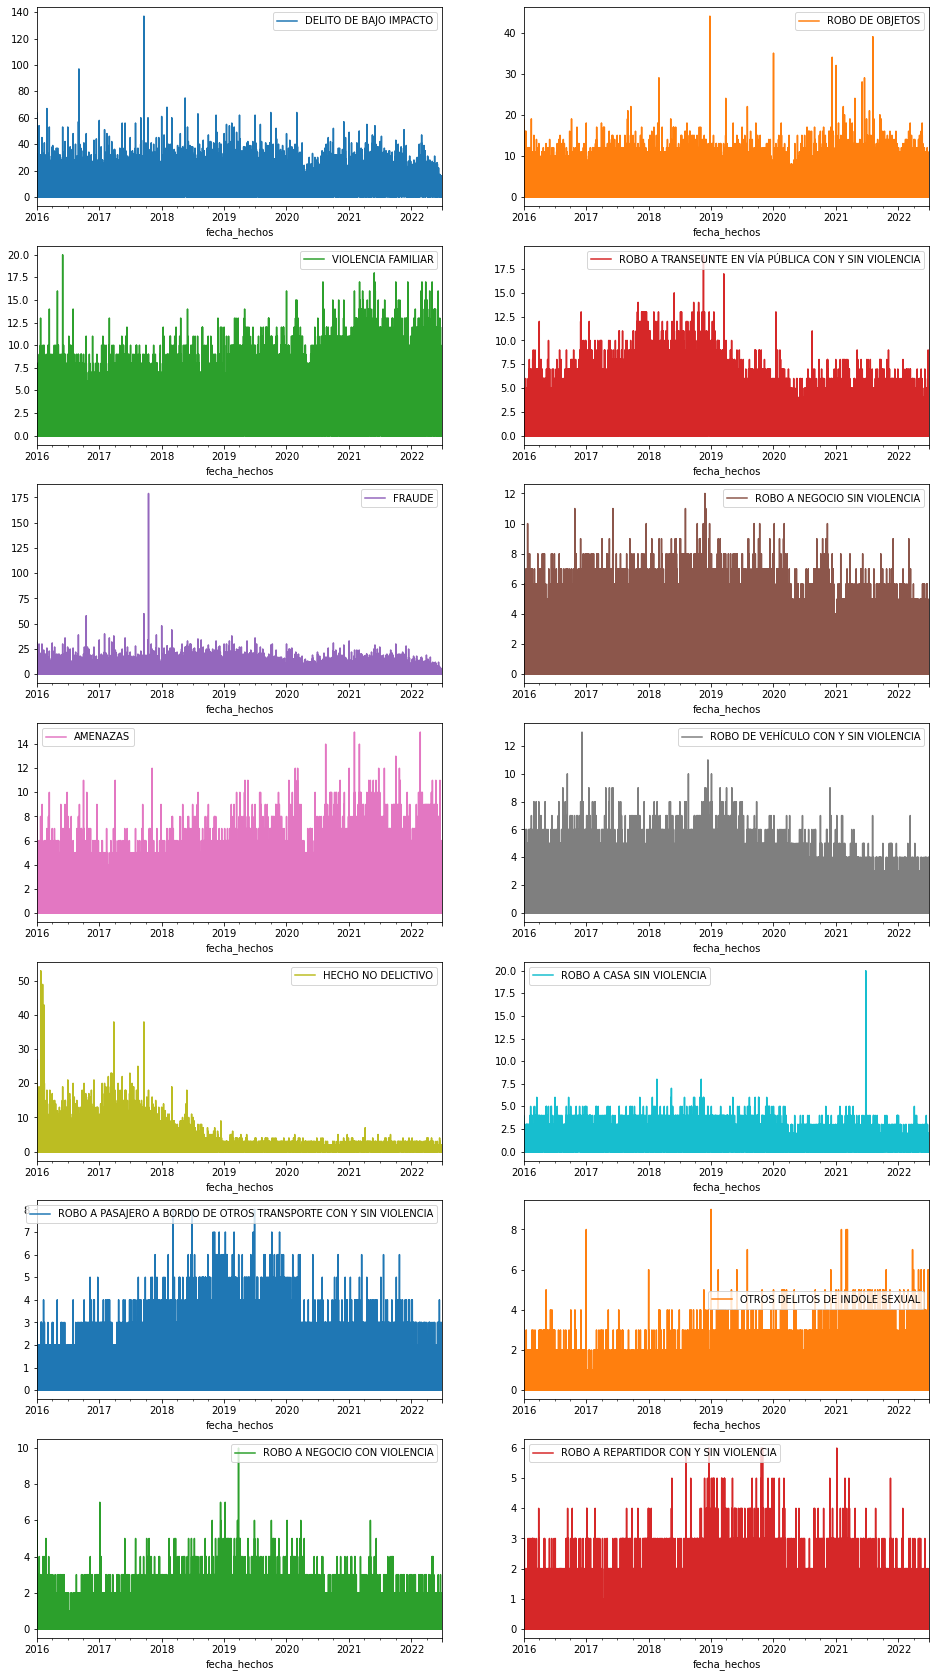

In [48]:
ts_hora.loc[:,top_cat].rolling(1).sum().plot(figsize=(16, 30), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

## Analisis de la hora de los delitos

In [49]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[1:14]
cat = top_cat[top_cat!="HECHO NO DELICTIVO"]

In [50]:
def scale_df(df,axis=0):
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort()
    cap = np.min([np.max(df_marginal_scaled), np.abs(np.min(df_marginal_scaled))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)

Relación entre tipo de delito y hora del día.

In [51]:
cat_x_hora = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.hour, aggfunc=np.size).fillna(0)

C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


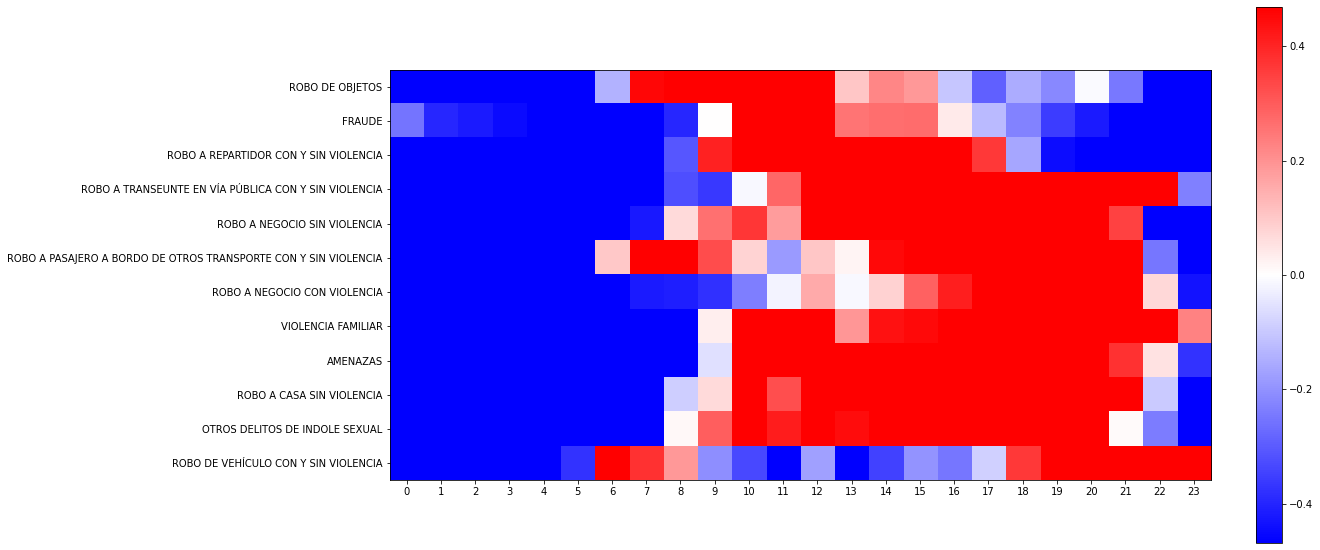

In [52]:
plt.figure(figsize=(16,10))
scale_and_plot(cat_x_hora.loc[cat,:])

Al graficar las series por separado de los delitos registrados por hora, se logra observar detalle la información del mapa de calor mostrado anteriromente.

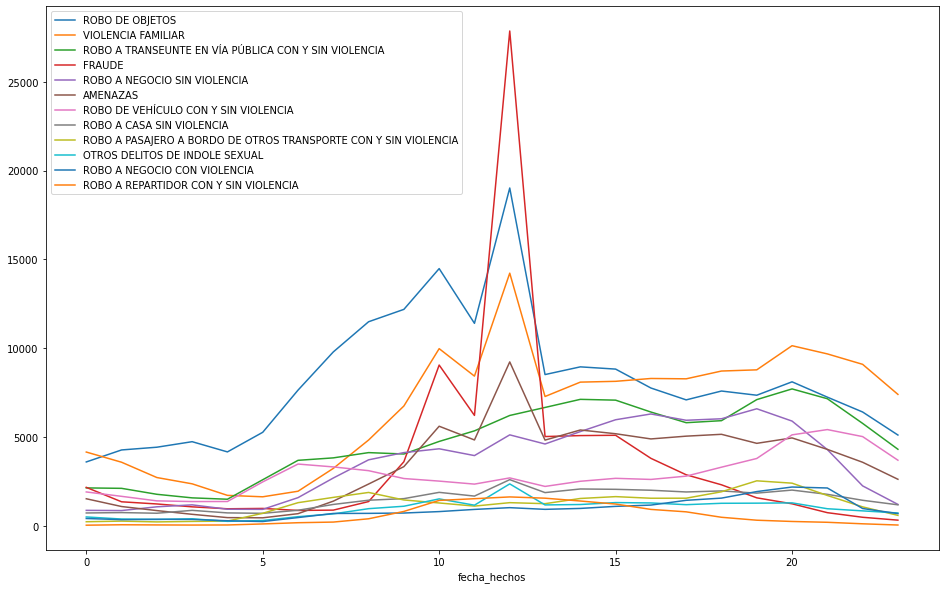

In [53]:
plt.figure(figsize=(16,10))
for i in range(12):
    cat_x_hora.loc[cat,:].iloc[i,].plot()
plt.legend()

Se observa que existen ciertos delitos de estudio que presentan una concentración de numero de delitos alrededor de las 12 pm. Por otro lado, otros delitos muestran una mayor concentracion de delitos en las noche. 

### Relación entre tipo de delito y la semana de registro.

In [54]:
cat_x_semana = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.week, aggfunc=np.size).fillna(0)

C:\Users\110395\AppData\Local\Temp\ipykernel_15588\2968587416.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  columns=FGJ_carpetas.index.week, aggfunc=np.size).fillna(0)


C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


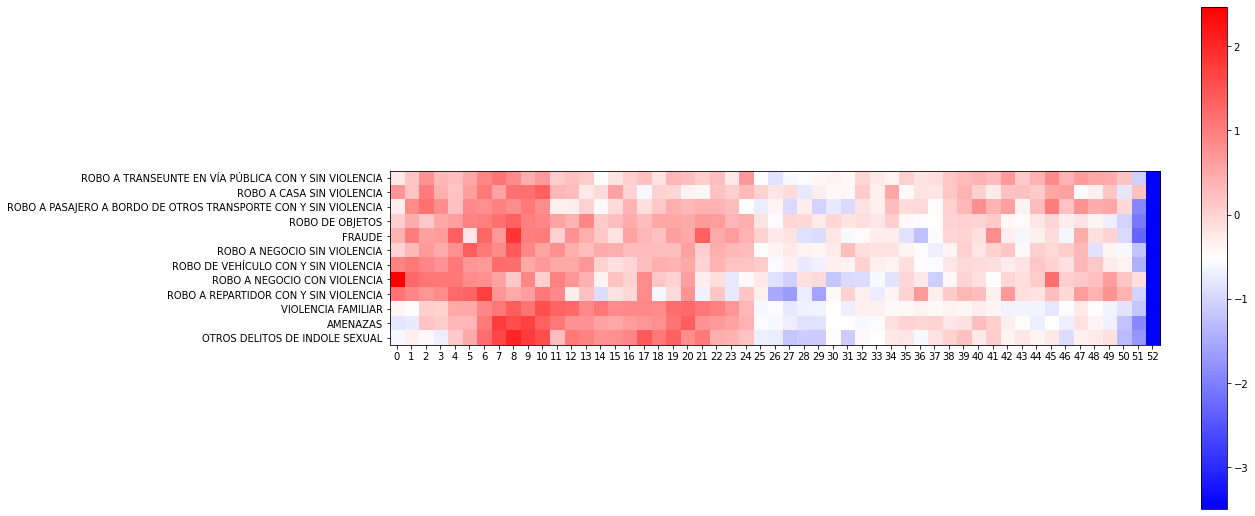

In [55]:
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_semana.loc[cat,:])

Los delitos por semana muestra una actividad más uniforme presentando más delitos en las primeras 25 semanas.

### Relación entre tipo de delito y dia del mes.

In [56]:
cat_x_dia = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.day, aggfunc=np.size).fillna(0)

C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


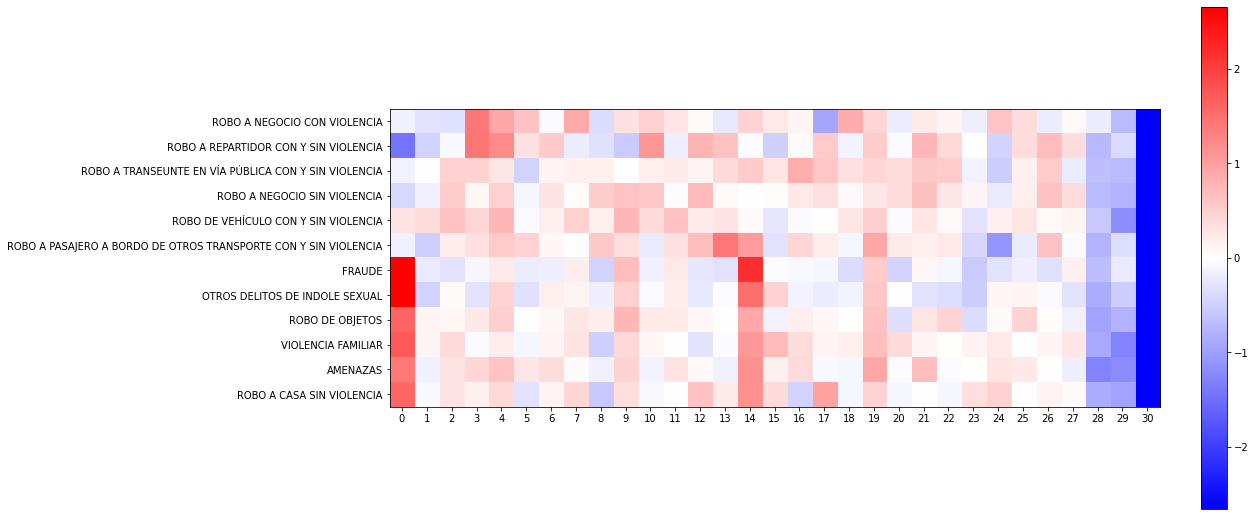

In [57]:
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_dia.loc[cat,:])

### Relación entre tipo de delito y dia de la semana.

In [58]:
cat_x_dia_semana = FGJ_carpetas.pivot_table(values = "delito", index = "categoria_delito_homo", 
                         columns=FGJ_carpetas.index.weekday, aggfunc=np.size).fillna(0)

C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


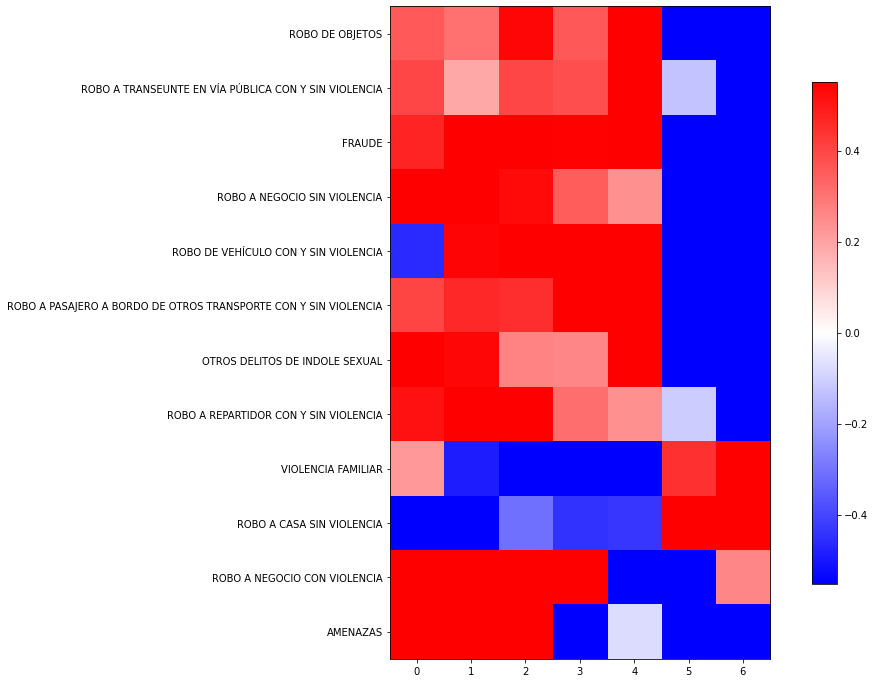

In [59]:
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_dia_semana.loc[cat,:])

La distribución de los delitos cometidos en base al dia de la semana presenta diferencias dependiendo el delito a estudiar.

### Relación entre la Delegación y hora del día.

In [62]:
hora_x_del = FGJ_carpetas.pivot_table(values = "delito", index='alcaldia_hechos', 
                                      columns=FGJ_carpetas.index.hour, aggfunc=np.size).fillna(0)

C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


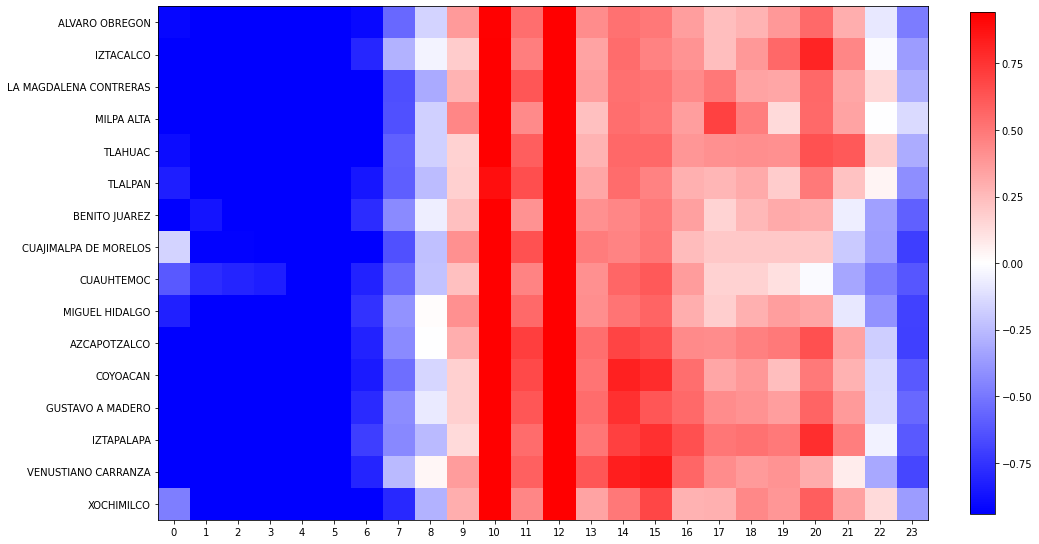

In [63]:
plt.figure(figsize=(15,12))
scale_and_plot(hora_x_del)

Relación entre la cantidad de delitos cometidos al día en cada hora.

In [13]:
hora_x_dia = FGJ_carpetas.pivot_table(values="Unnamed: 0", index=FGJ_carpetas.index.hour, 
                                      columns=FGJ_carpetas.index.weekday, aggfunc=np.size).fillna(0)
hora_x_dia     = hora_x_dia.T

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


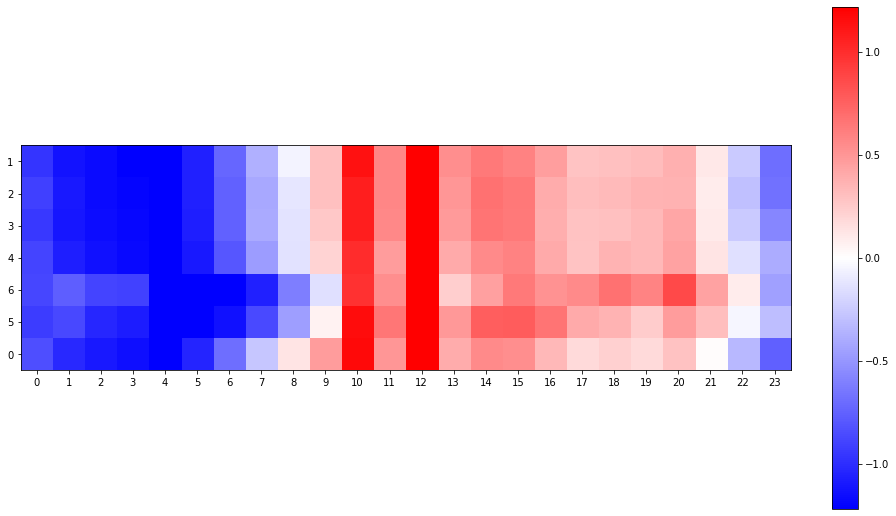

In [14]:
plt.figure(figsize=(15,12))
scale_and_plot(hora_x_dia, ix=np.arange(7))

Relacipon cantidad de delitos al día por delegación.

C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Joshi\anaconda3\envs\ciencia_de_datos\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


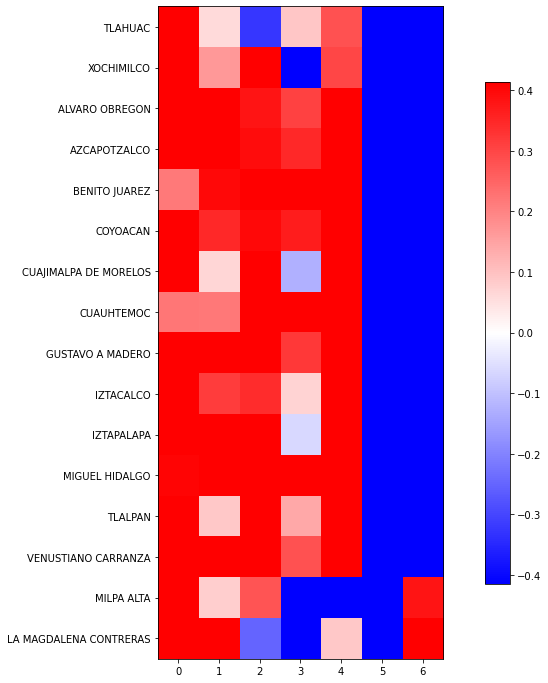

In [19]:
del_x_dia = FGJ_carpetas.pivot_table(values="Unnamed: 0", index=FGJ_carpetas.index.weekday, 
                                      columns="alcaldia_hechos", aggfunc=np.size).fillna(0)
del_x_dia     = del_x_dia.T
plt.figure(figsize=(15,12))
scale_and_plot(del_x_dia)

Relación de los delitos por tipo y delegación.

C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\110395\anaconda3\envs\TS\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


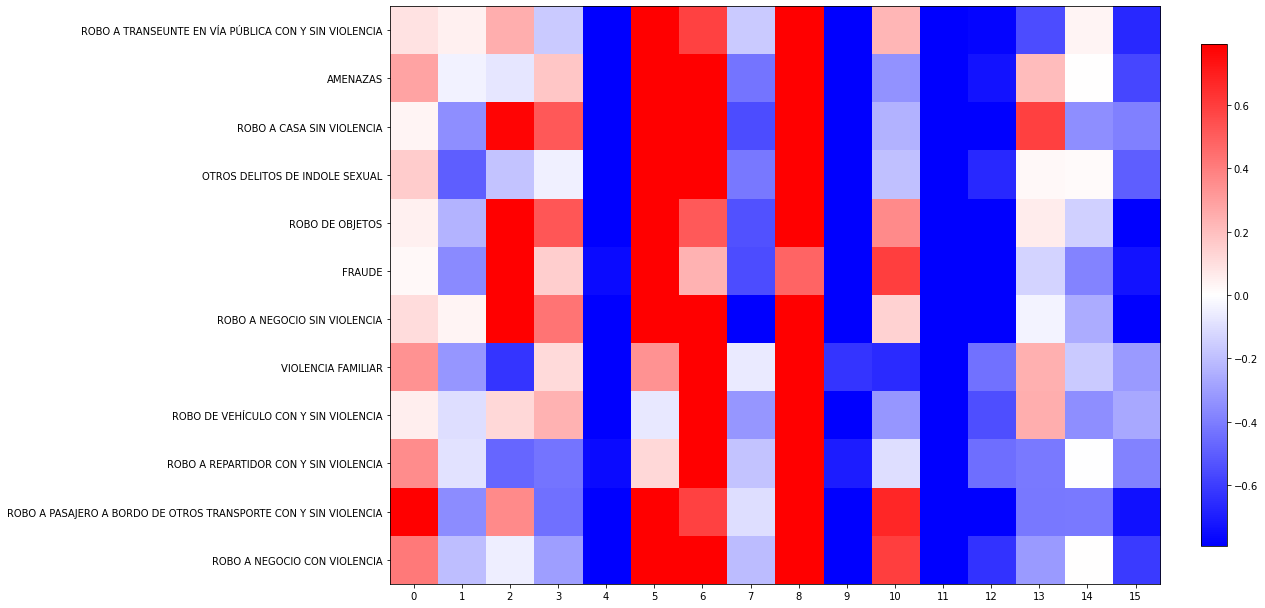

In [64]:
cat_x_del = FGJ_carpetas.pivot_table(values="delito", index="alcaldia_hechos", 
                                      columns="categoria_delito_homo", aggfunc=np.size).fillna(0)
cat_x_del     = cat_x_del.T
plt.figure(figsize=(15,12))
scale_and_plot(cat_x_del.loc[cat,:])

In [67]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

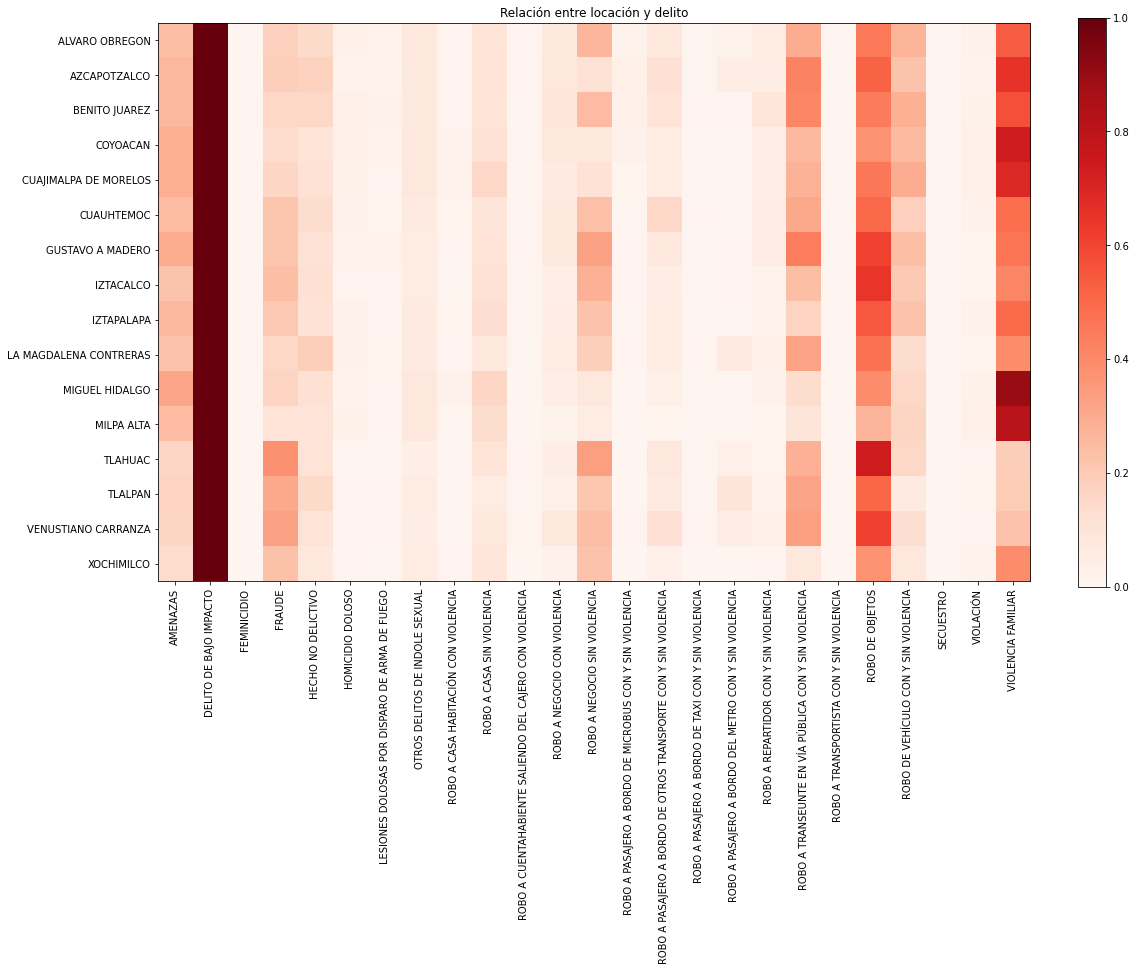

In [95]:
df = normalize(cat_x_del)
ix = AC(5).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Relación entre locación y delito')
plt.grid(False)
plt.show()

## Clustering a las Series por categoria: K-means

### Clustering con la metrica DTW

In [68]:
km_euc = TimeSeriesKMeans(n_clusters=3, 
                          verbose=2, 
                          n_init=10, 
                          metric="euclidean").fit(ts_semana.loc[:,cat].transpose())
labels_euc = km_euc.labels_
print(silhouette_score(ts_semana.loc[:,cat].transpose(), labels_euc, metric="euclidean"))
print(labels_euc)

Init 1
2965580.583 --> 1494086.400 --> 1494086.400 --> 
Init 2
2496080.083 --> 1494086.400 --> 1494086.400 --> 
Init 3
4123131.917 --> 1897296.585 --> 1494086.400 --> 1494086.400 --> 
Init 4
2411628.083 --> 1494086.400 --> 1494086.400 --> 
Init 5
2965580.583 --> 1494086.400 --> 1494086.400 --> 
Init 6
4102441.250 --> 2655794.242 --> 1956336.407 --> 1494086.400 --> 1494086.400 --> 
Init 7
2700789.083 --> 1494086.400 --> 1494086.400 --> 
Init 8
2669216.833 --> 1494086.400 --> 1494086.400 --> 
Init 9
4123131.917 --> 1897296.585 --> 1494086.400 --> 1494086.400 --> 
Init 10
3671662.417 --> 1897296.585 --> 1494086.400 --> 1494086.400 --> 
0.5372296648085747
[1 1 2 2 2 2 2 0 0 0 0 0]


array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

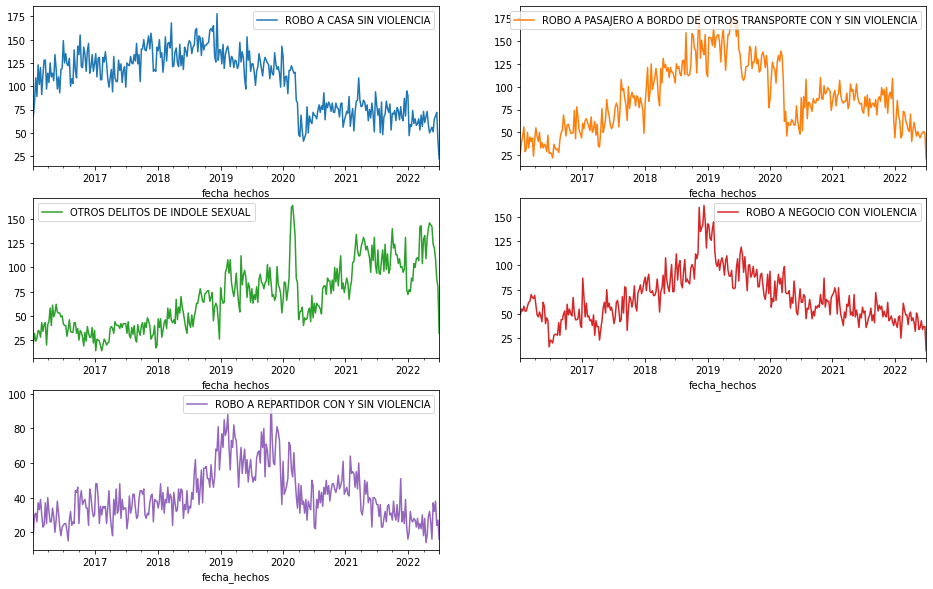

In [69]:
ts_semana.loc[:,cat].iloc[:,labels_euc==0].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

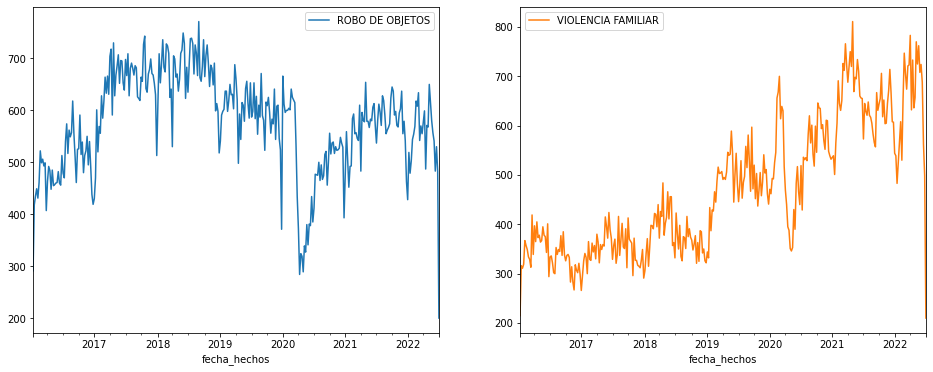

In [72]:
ts_semana.loc[:,cat].iloc[:,labels_euc==1].plot(figsize=(16, 6), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

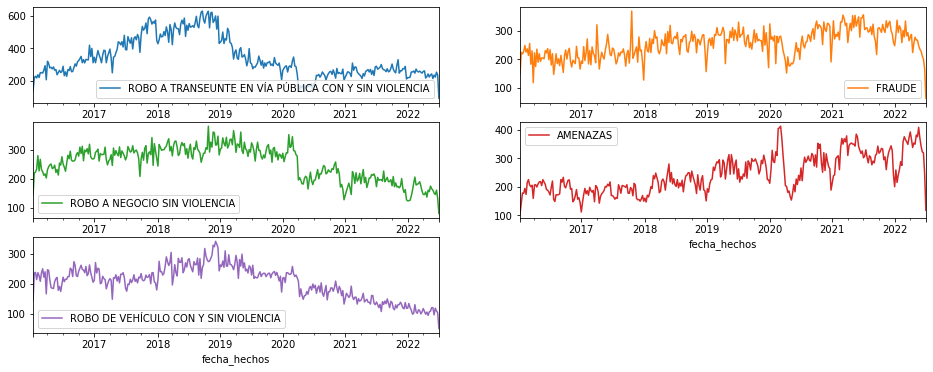

In [71]:
ts_semana.loc[:,cat].iloc[:,labels_euc==2].plot(figsize=(16, 6), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

### Clustering con la metrica DTW

In [76]:
km_dtw = TimeSeriesKMeans(n_clusters=3, 
                          verbose=2, 
                          n_init=10, 
                          metric="dtw").fit(ts_semana.loc[:,cat].transpose())
labels_dtw = km_dtw.labels_
print(silhouette_score(ts_semana.loc[:,cat].transpose(), labels_dtw, metric="dtw"))
print(labels_dtw)

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


384177.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


163229.296 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


163229.296 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


431416.583 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


168001.152 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


168001.152 --> 
Init 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


365862.917 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


169921.339 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


169921.339 --> 
Init 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


343607.250 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


166625.967 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


166625.967 --> 
Init 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


447499.583 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


165573.629 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


165573.629 --> 
Init 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


364367.500 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


154899.264 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


154899.264 --> 
Init 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


424001.917 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


150689.210 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


150689.210 --> 
Init 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


358156.917 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


166340.699 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


166340.699 --> 
Init 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


372073.500 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


158479.904 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


158479.904 --> 
Init 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


325074.583 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


153259.081 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


153259.081 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


0.7091913616221618
[0 0 0 2 2 2 2 1 1 1 1 1]


array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

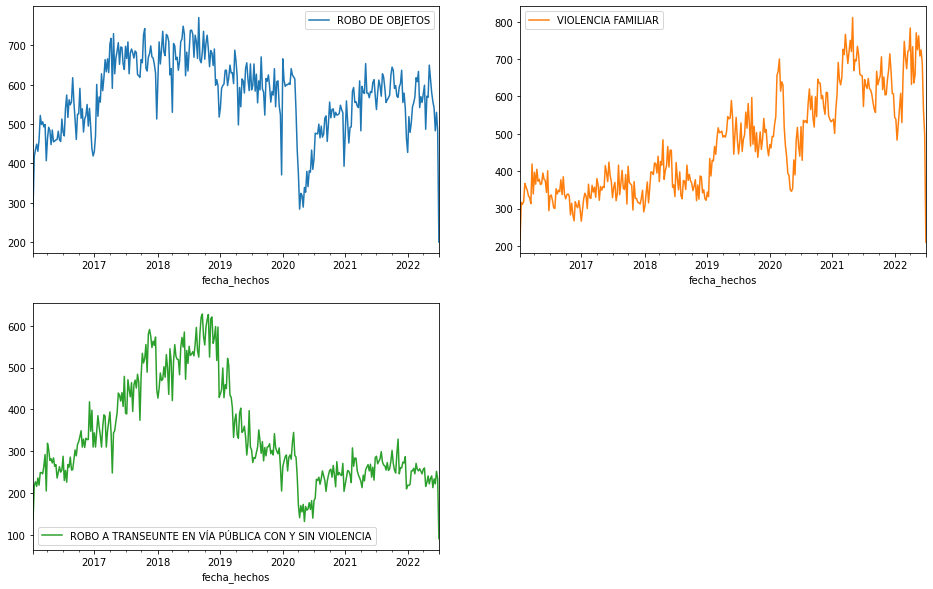

In [77]:
ts_semana.loc[:,cat].iloc[:,labels_dtw==0].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

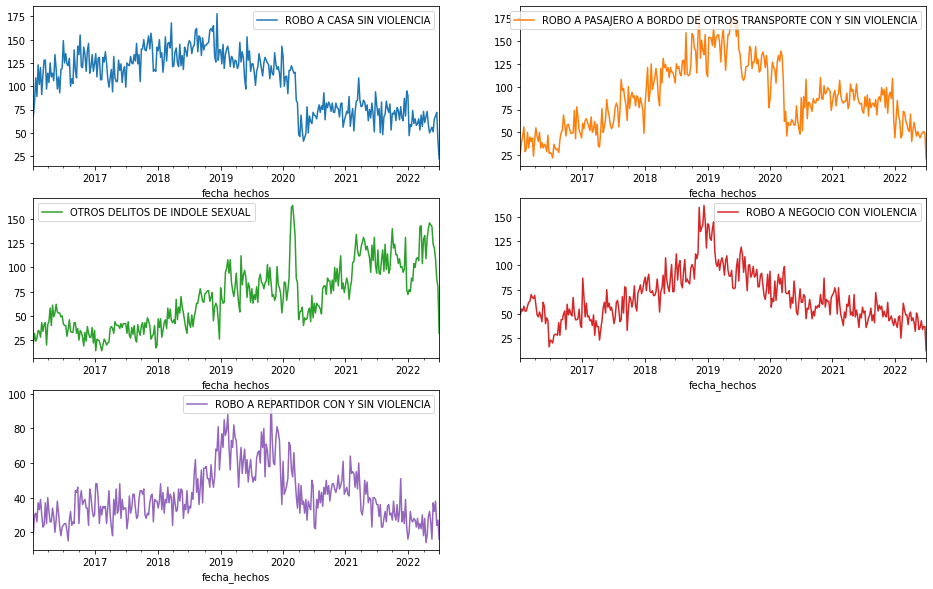

In [78]:
ts_semana.loc[:,cat].iloc[:,labels_dtw==1].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

array([[<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>],
       [<AxesSubplot:xlabel='fecha_hechos'>,
        <AxesSubplot:xlabel='fecha_hechos'>]], dtype=object)

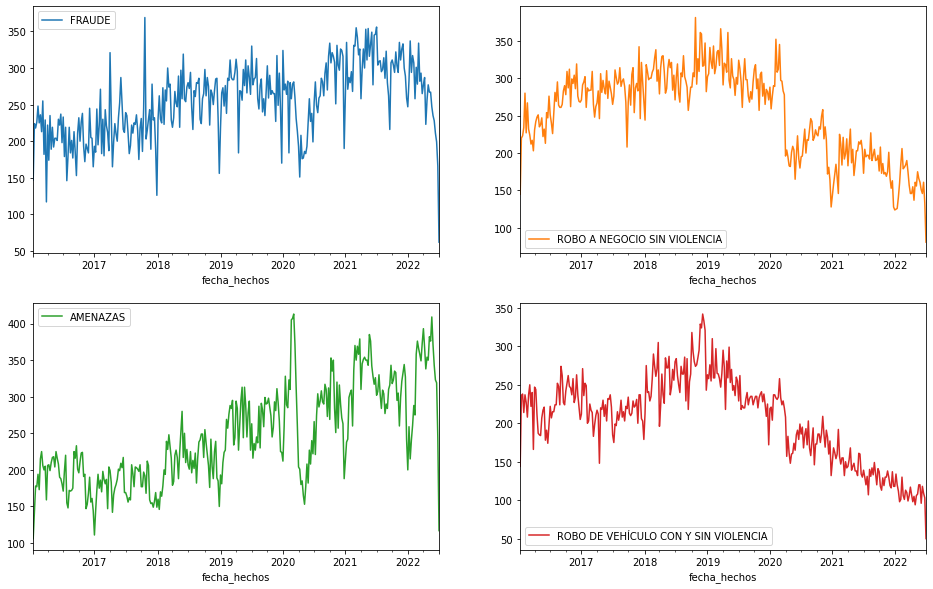

In [79]:
ts_semana.loc[:,cat].iloc[:,labels_dtw==2].plot(figsize=(16, 10), subplots=True, layout=(-1, 2), sharex=False, sharey=False)